# <span style="color:blue"> Monoasset test: Pricing European Option </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import DiscountingCurve, EquityForwardCurve, Black,ForwardVariance,Vanilla_PayOff
from montecarlo import MC,MC_Analisys
import lets_be_rational.LetsBeRational as lbr
from closedforms import European_option_closed_form, StrikeFromDelta
import scipy.stats as si
import time, sys
from scipy import log, sqrt, exp
from matplotlib import ticker

### Parameters of Simulation

In [2]:
r = 1/100
t = 0
volatility = 20/100
spot_price = 150
T_max = 10.
N_simulations = 1e6
N_block = 100

### Market Data

zero interest rate time grid [ 0.  5. 10.]
zero interest rate:  [0.01 0.01 0.01]


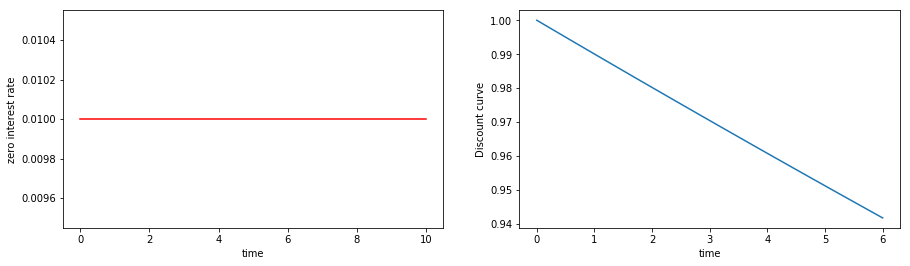

In [3]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.0,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.step(zero_interest_rate_dates, D.r(zero_interest_rate_dates), color="red")
plt.xlabel("time")
plt.ylabel("zero interest rate")

plt.subplot(1,2,2)
x = np.linspace(0.,6,100)
plt.plot(x,D(x))
plt.xlabel("time")
plt.ylabel("Discount curve")
plt.show()

Forward repo time grid [ 0. 10.]
Forward repo rate:  [0. 0.]


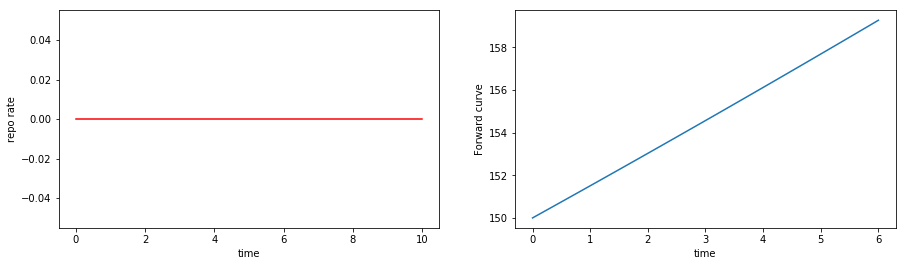

In [4]:
"""Forward curve and repo rates"""
F = EquityForwardCurve(reference=t, discounting_curve=D, spot=spot_price,repo_dates=np.array([0.,T_max]), repo_rates=np.array([0.,0.]))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.step(F.T, F.q, color="red")
plt.xlabel("time")
plt.ylabel("repo rate")

plt.subplot(1,2,2)
plt.plot(x,F(x))
plt.xlabel("time")
plt.ylabel("Forward curve")
plt.show()

Forward volatility time grid:  [ 0.1 10. ]
Forward volatility:  [0.2 0.2]


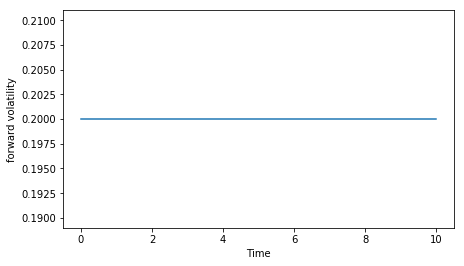

In [5]:
"""Time dependent volatility"""
K_spot_vola = np.array([spot_price,200])
spot_vol = np.array(([volatility,volatility],[0.3,0.3]))
spot_vol_dates = np.array([0.1,T_max])
V = ForwardVariance(reference=t,maturities=spot_vol_dates,strikes=K_spot_vola,spot_volatility=spot_vol,strike_interp=spot_price)

plt.figure(figsize=(7,4))
time = V.T.tolist()
vola = V.forward_vol.tolist()
time.insert(0,V.T[0])
time.insert(0,0)
vola.insert(0,V.forward_vol[0])
vola.insert(0,V.forward_vol[0])
plt.step(time, vola)
plt.xlabel("Time")
plt.ylabel("forward volatility")
plt.show()


### Simulation

In [6]:
%%time
kind = 1
B_model = Black(variance=V, forward_curve=F)
maturities = np.arange(1,31)*0.15
S_t = B_model.simulate(fixings=maturities, Nsim=N_simulations, seed=12)
X_t = S_t/F(maturities)
E_X = np.mean(X_t,axis=0)
K_norm = 1
pay_normalized = Vanilla_PayOff(St=X_t,strike=K_norm, typo=kind)  #ATM forward pricing

"""Calculating closed form"""
call_black = European_option_closed_form(forward=F(maturities), strike=F(maturities), maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)

Single Asset Simulation
Wall time: 22.5 s


### Convergence Check

#### In term of price

In [7]:
n = 26
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
mean_price = result*D(maturities[n])*F(maturities[n])
err_price = result_err*D(maturities[n])*F(maturities[n])

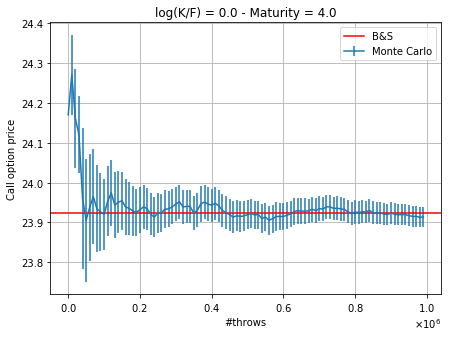

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.title("log(K/F) = "+str(log(K_norm))+" - Maturity = "+str(round(maturities[n],1)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/European_call_option.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/European_put_option.pdf')
plt.show()

C:\Users\Stefano\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


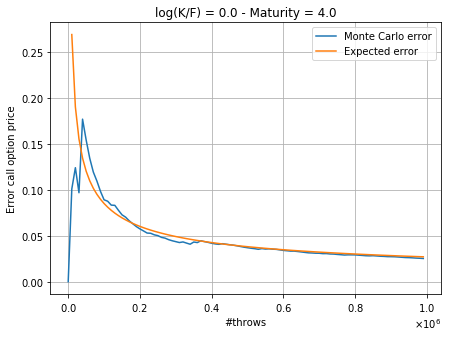

In [9]:
z = np.std(pay_normalized.T[n])*F(maturities[n])*D(maturities[n])
y = np.sqrt(x)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("log(K/F) = "+str(log(K_norm))+" - Maturity = "+str(round(maturities[n],1)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind==1:
    plt.ylabel('Error call option price')
   # plt.savefig('Graphs/Error_euro_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
    #plt.savefig('Graphs/Error_euro_put_option.pdf')

plt.show()

#### In term of implied volatility

In [10]:
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E_X[n],1,maturities[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],E_X[n],1,maturities[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],E_X[n],1,maturities[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


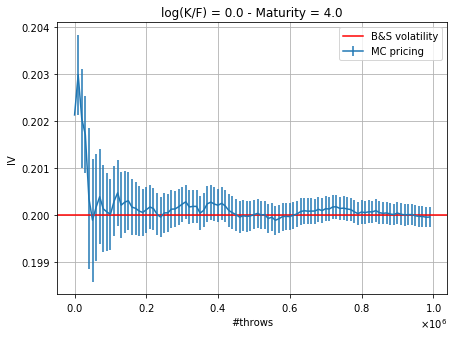

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("log(K/F) = "+str(log(K_norm))+" - Maturity = "+str(round(maturities[n],1)))
plt.errorbar(x,imp_volatility_mean,yerr=[y_lower,y_upper], label = "MC pricing")
plt.axhline(y=volatility,color= "red",linestyle='-',label = 'B&S volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
plt.show()

### Implied volatility in function of log Moneyness log(K/F)

In [14]:
%%time
kind = -1
logmoneyness =np.arange(-10,11)*0.1
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(logmoneyness)):
    if logmoneyness[i]>=0.:
        kind =1
    elif logmoneyness[i]<0.:
        kind =-1
    K = np.exp(logmoneyness[i])
    option = Vanilla_PayOff(St=X_t, strike=K,typo=kind)
    result, err_result = MC(option)
    for j in range(len(maturities)):
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K,maturities[j],kind)
        
print("Saving_Files...")
#np.savetxt("Results/norm_implied_volatility_mean_log.txt",imp_volatility)    #saving results
#np.savetxt("Results/norm_implied_volatility_minus_log.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results/norm_implied_volatility_plus_log.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results/norm_moneyness_log.txt",logmoneyness)
#np.savetxt("Results/norm_maturities_log.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Saving_Files...
COMPLETED
Wall time: 1min 57s


In [15]:
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])


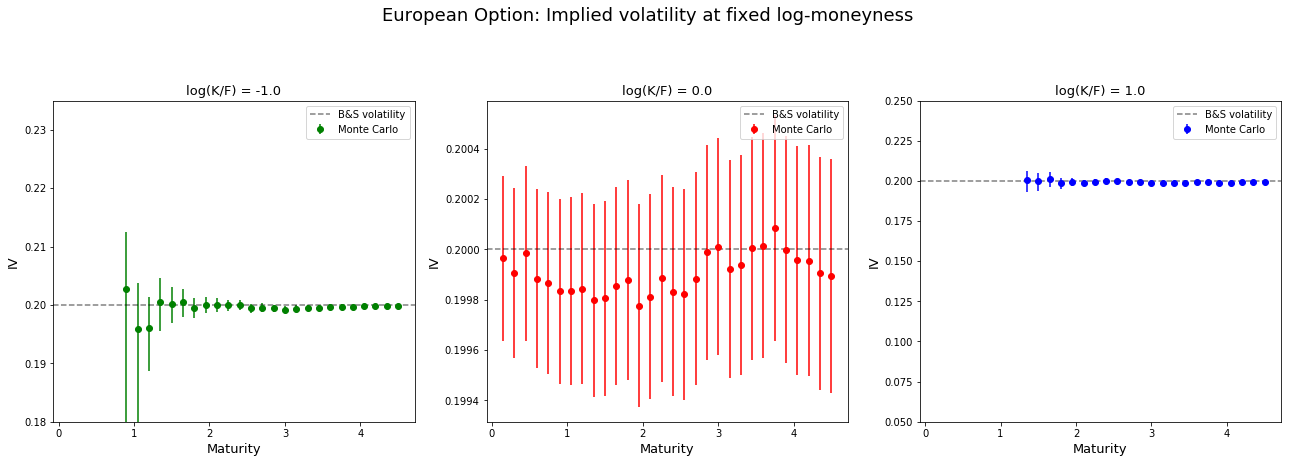

In [16]:
plt.figure(figsize=(22,13))
plt.suptitle("European Option: Implied volatility at fixed log-moneyness",fontsize=18)
n_sigma = 2  #how many sigma for the errorbars
i=0
num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "green",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.ylim(0.18,0.235)  
plt.legend()

num = [10] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.legend()

num = [20]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "blue",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.ylim(0.05,0.25)
plt.legend()
plt.show()

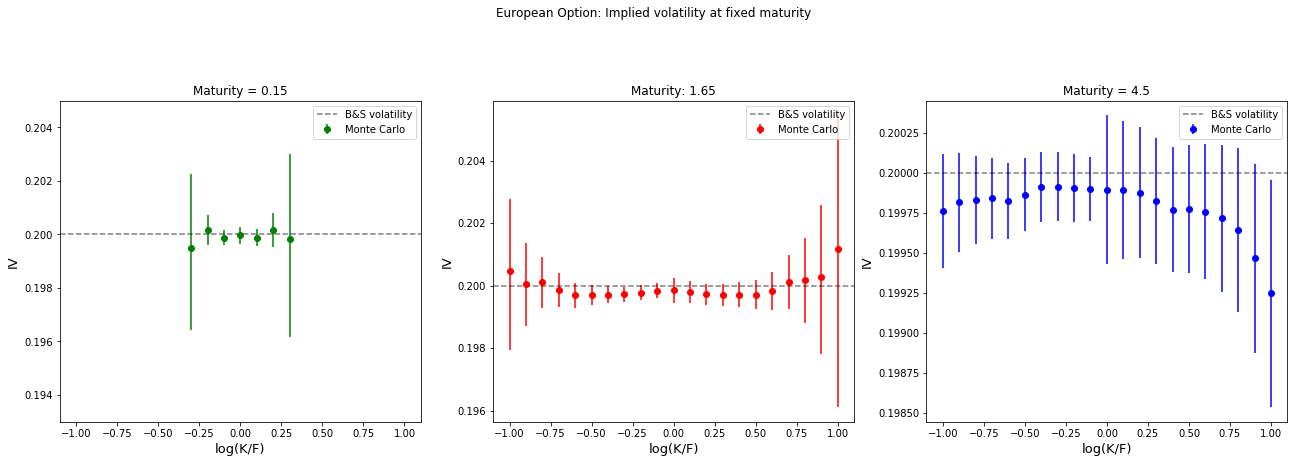

In [17]:
plt.figure(figsize=(22,13))
plt.suptitle("European Option: Implied volatility at fixed maturity")
n_sigma = 2   #how many sigma for the errorbars

num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="green",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)))
plt.ylim(0.193,0.205)
plt.legend()

num = [10] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="red",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
plt.legend()

num = [29]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)))
plt.legend()
plt.show()

### Results in term of Delta

In [16]:
%%time
kind = -1
delta = np.arange(2,21)*0.05
imp_volatility = np.zeros((len(delta),len(maturities)))
imp_volatility_plus = np.zeros((len(delta),len(maturities)))
imp_volatility_minus = np.zeros((len(delta),len(maturities)))
X_t = S_t/F(maturities)
E_X = np.mean(X_t,axis=0)
for j in range(len(maturities)):
    if j%10 == 0:
        print("Running: ",j,"%")
    for i in range(len(delta)):
        K = StrikeFromDelta(F,maturities[j],t,delta[i],volatility)
        if K >= F(maturities[j]):
            kind = 1  #1 buono
           # print("Sono una call")
        elif K<F(maturities[j]):
            kind = -1  #-1 buono
          #  print("Sono una put")
        option = Vanilla_PayOff(St=X_t, strike=K/F(maturities),typo=kind)
        result, err_result = MC(option)
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)

    
print("Saving_Files...")
#np.savetxt("Results/norm_implied_volatility_mean_delta.txt",imp_volatility)    #saving results
#np.savetxt("Results/norm_implied_volatility_minus_delta.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results/norm_implied_volatility_plus_delta.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results/norm_moneyness_delta.txt",delta)
#np.savetxt("Results/norm_maturities_delta.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Saving_Files...
COMPLETED
Wall time: 52min 14s


In [17]:
y_lower = np.zeros((len(delta),len(maturities)))
y_upper = np.zeros((len(delta),len(maturities)))
for i in range(len(delta)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])
            if abs(imp_volatility[i][j])>100:
                imp_volatility[i][j] = None
          

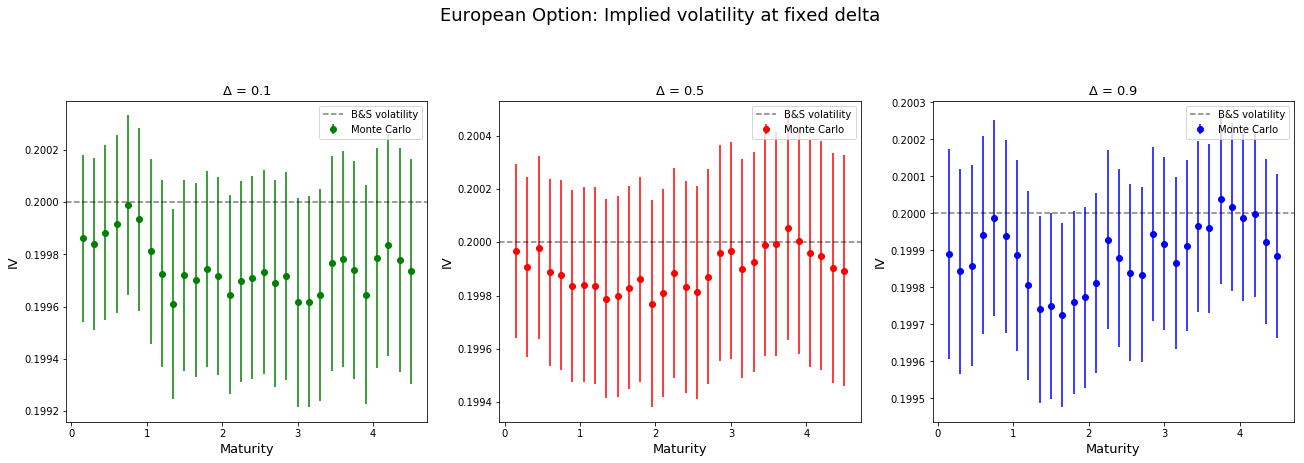

In [18]:
"""Fixed Delta"""
plt.figure(figsize=(22,13))
plt.suptitle("European Option: Implied volatility at fixed delta",fontsize=18)
n_sigma = 2
i=0
num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "green",label="Monte Carlo")
plt.title("$\Delta$ = "+str(round(delta[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.legend()

num = [8] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
plt.title("$\Delta$ = "+str(round(delta[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.legend()

num = [16]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "blue",label="Monte Carlo")
plt.title("$\Delta$ = "+str(round(delta[num[i]],c)),fontsize=13)
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.legend()
plt.show()

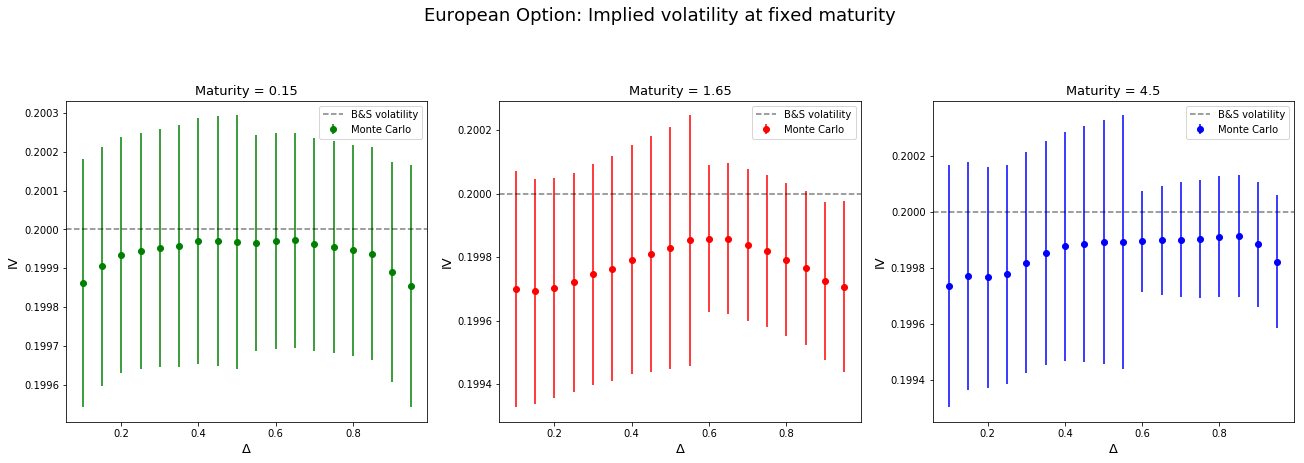

In [19]:
"""Fixed maturity"""
plt.figure(figsize=(22,13))
plt.suptitle("European Option: Implied volatility at fixed maturity",fontsize=18)
n_sigma = 2

num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(delta,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="green",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("$\Delta$",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)),fontsize=13)
plt.legend()

num = [10] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(delta,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="red",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("$\Delta$",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)),fontsize=13)
plt.legend()

num = [29]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(delta,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=volatility, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("$\Delta$",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)),fontsize=13)
plt.legend()
plt.show()

### Test asimmetria dell'errore tra call e put ad ATM

In [18]:
%%time
kind =1
ATM = 10
S_t = B_model.simulate(fixings=maturities,Nsim=N_simulations, seed=7) #9,8
print("Il Forward è ",F(maturities))
logmoneyness =np.arange(-10,11)*0.1
K1 =F(maturities)* np.exp(logmoneyness[ATM])
print("Strike per call:",K1)
option1 = Vanilla_PayOff(St=S_t, strike=K1,typo=kind)*D(maturities)  #call
x1,r1,e1 = MC_Analisys(option1,N_block)
kind =-1
K1 =F(maturities)* np.exp(logmoneyness[ATM])
print("Strike per put:",K1)
option2 = Vanilla_PayOff(St=S_t, strike=K1,typo=kind)*D(maturities)  #put
x2,r2,e2 = MC_Analisys(option2,N_block)

Single Asset Simulation
Il Forward è  [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 152.49553152 152.72444646 152.95370503 153.18330775 153.41325512
 153.64354768 153.87418594 154.10517041 154.33650163 154.56818009
 154.80020634 155.03258089 155.26530426 155.49837697 155.73179956
 155.96557255 156.19969646 156.43417181 156.66899915 156.90417899]
Strike per call: [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 152.49553152 152.72444646 152.95370503 153.18330775 153.41325512
 153.64354768 153.87418594 154.10517041 154.33650163 154.56818009
 154.80020634 155.03258089 155.26530426 155.49837697 155.73179956
 155.96557255 156.19969646 156.43417181 156.66899915 156.90417899]
Strike per put: [150.22516883 150.45067568 150.67652103 150.90270541 151.12922932
 151.35609327 151.58329777 151.81084333 152.03873047 152.26695969
 15

In [26]:
%%time
counter = 0
for i in range(len(maturities)):
    for j in range(len(option1)):
        if option1[j,i] ==0:
            counter = counter+1
            
print("Numero di zeri per la call",counter)

Numero di zeri per la call 3446342
Wall time: 56.6 s


In [27]:
%%time
counter2 = 0
for i in range(len(maturities)):
    for j in range(len(option2)):
        if option2[j,i] ==0:
            counter2 = counter2+1
            
print("Numero di zeri per la put",counter2)
if counter2>counter:
    print("La put presenta più zeri nel payoff")
else:
    print("La call presenta più zeri nel payoff")

Numero di zeri per la put 0
La call presenta più zeri nel payoff
Wall time: 54.9 s


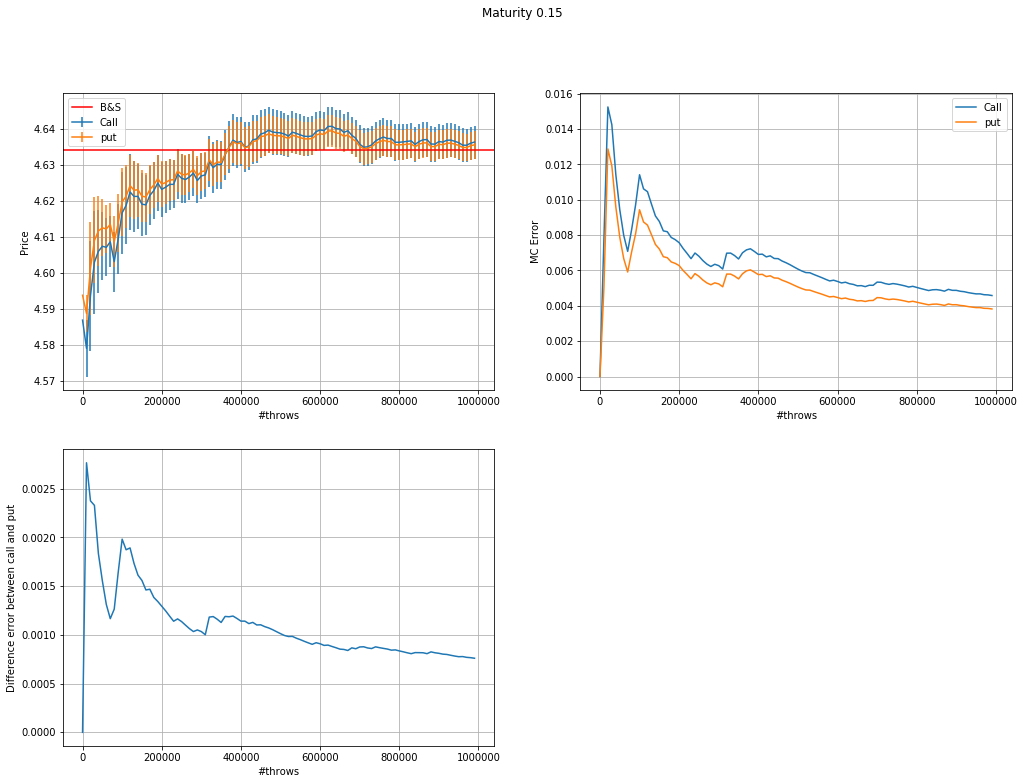

In [28]:
n = 0
plt.figure(figsize=(17,12))
plt.suptitle("Maturity "+str(round(maturities[n],2)))
call_black = European_option_closed_form(forward=F(maturities), strike=K1[n], maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)
plt.subplot(2,2,1)
plt.errorbar(x1,r1.T[n],yerr=e1.T[n],label="Call")
plt.errorbar(x2,r2.T[n],yerr=e2.T[n],label="put")
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.ylabel("Price")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(x1,e1.T[n],label="Call")
plt.plot(x2,e2.T[n],label="put")
plt.legend()
plt.grid(True)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.ylabel("MC Error")

plt.subplot(2,2,3)
plt.plot(x1,abs(e1.T[n]-e2.T[n]))
plt.grid(True)
plt.ylabel("Difference error between call and put")
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

plt.show()

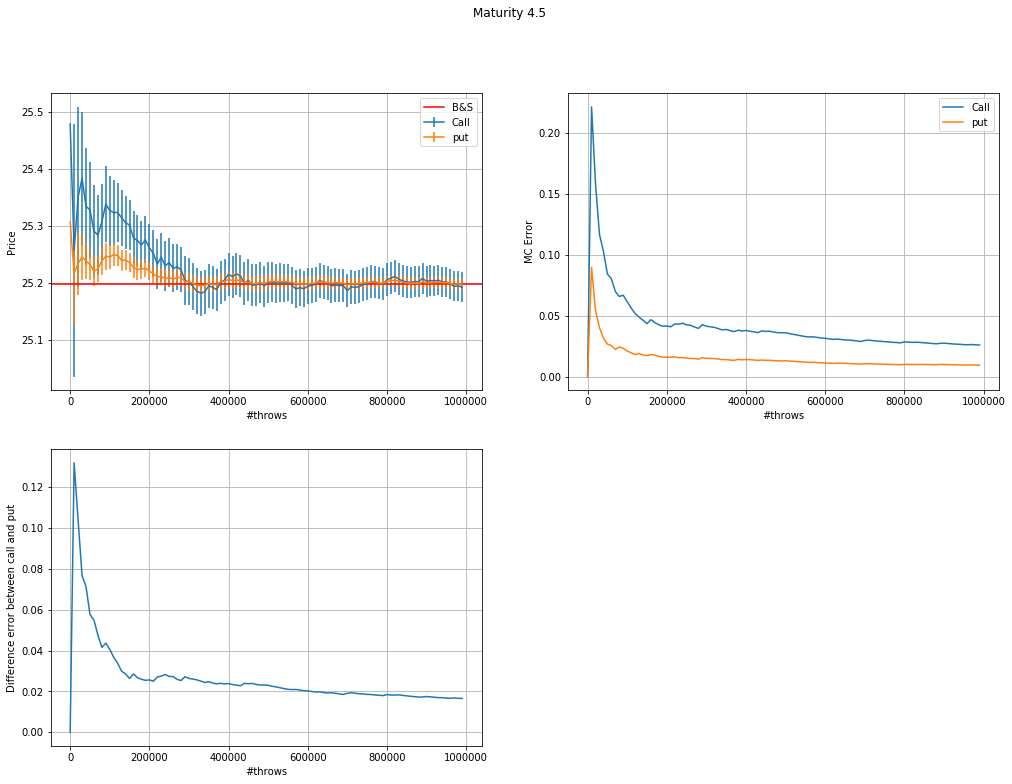

In [29]:
n = len(r1.T)-1
plt.figure(figsize=(17,12))
plt.suptitle("Maturity "+str(round(maturities[n],2)))
call_black = European_option_closed_form(forward=F(maturities), strike=K1[n], maturity=maturities, reference=t, volatility=volatility, zero_interest_rate=r, typo = kind)
plt.subplot(2,2,1)
plt.errorbar(x1,r1.T[n],yerr=e1.T[n],label="Call")
plt.errorbar(x2,r2.T[n],yerr=e2.T[n],label="put")
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.ylabel("Price")

plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(x1,e1.T[n],label="Call")
plt.plot(x2,e2.T[n],label="put")
plt.legend()
plt.grid(True)
plt.xlabel("#throws")

plt.ylabel("MC Error")

plt.subplot(2,2,3)
plt.plot(x1,abs(e1.T[n]-e2.T[n]))
plt.grid(True)
plt.ylabel("Difference error between call and put")
plt.xlabel("#throws")
plt.show()

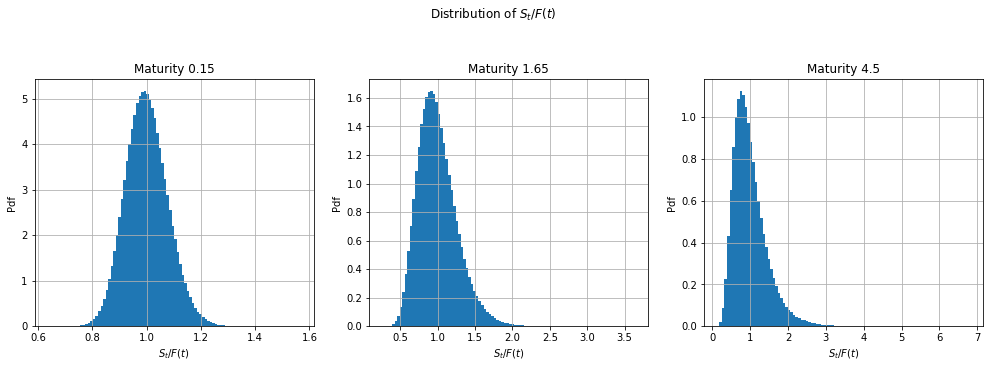

In [30]:
X_t = S_t/F(maturities)
N_bins = 100
plt.figure(figsize=(17,10))
plt.suptitle("Distribution of $S_t/F(t)$")
plt.subplot(2,3,1)
n=0
plt.hist(X_t.T[n],normed=1,bins=N_bins)
plt.title("Maturity "+str(round(maturities[n],2)))
plt.xlabel(r"$S_t/F(t)$")
plt.ylabel("Pdf")
plt.grid(True)

plt.subplot(2,3,2)
n=10
plt.hist(X_t.T[n],normed=1,bins=N_bins)
plt.title("Maturity "+str(round(maturities[n],2)))
plt.xlabel(r"$S_t/F(t)$")
plt.ylabel("Pdf")
plt.grid(True)

plt.subplot(2,3,3)
n=len(X_t.T)-1
plt.hist(X_t.T[n],normed=1,bins=N_bins)
plt.title("Maturity "+str(round(maturities[n],2)))
plt.xlabel(r"$S_t/F(t)$")
plt.ylabel("Pdf")
plt.grid(True)
plt.show()

In [31]:
result1 ,errore_result1 = MC(option1)
result2 ,errore_result2 = MC(option2)

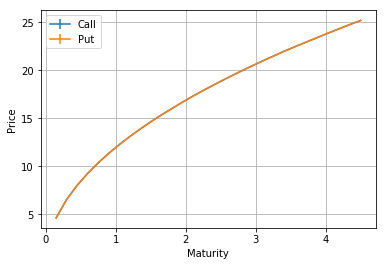

In [32]:
plt.errorbar(maturities,result1,yerr=errore_result1,label="Call")
plt.errorbar(maturities,result2,yerr=errore_result2,label="Put")
plt.legend()
plt.grid(True)
plt.xlabel("Maturity")
plt.ylabel("Price")
plt.show()

## OTHER RESULTS

### Result for a fixed strike K = 1 [$S_0$] in pricing therms

### Result at fixed Maturity [T=4] in terms of price